In [1]:
import os
import argparse
import wandb
import re
import clip
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# add the parent directory to the path
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
                
from utils.dcbm import *



/home/pknab/miniconda3/envs/envi/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-11-12 19:44:14.460292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-12 19:44:14.460326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# ----------------- Fix -----------------
embed_path = "../data/Embeddings/"
dataset = "cub"
class_labels_path = "../data/classes/cub_classes.txt"
segment_path = "../data/Segments/"
selected_image_concepts = "../data/Embeddings/subsets"
raw_path_dataset = # TODO
raw_path = #TODO: Define the path to the raw images

# ----------------- Hyperparameters -----------------

model_name = "CLIP-ViT-L14"  # "CLIP-ViT-L14", "CLIP-RN50", CLIP-ViT-B16

segmentation_technique = "SAM2"  # GDINO, SAM, SAM2, DETR, MaskRCNN
concept_name = None # Define for GDINE [awa, sun, sun-lowthresh, cub...]

device = "cpu"

clusters = 2048
cluster_method = "kmeans"  # "hierarchical", "kmeans"
centroid_method = "median"  # "mean", "median"

concept_per_class = 50  # How many images for each class 5,10,20,50, None

one_hot = False
epochs = 200
lambda_1 = 1e-4
lr = 1e-4
batch_size = 32

crop = False  # True without background

use_wandb = False
project = "YOUR_PROJECT_NAME"  # Define your own project name within wandb

In [4]:
cbm = CBM(
    embed_path, dataset, model_name, class_labels_path, device=device
)  # Initialize CBM

cbm.load_concepts(
    segment_path,
    segmentation_technique,
    concept_name,
    selected_image_concepts,
    concept_per_class,
    crop=crop,
)  # Load concepts with predefined segmentation technique and hyperparameters

if clusters is not None:  # if clustering is needed
    cbm.cluster_image_concepts(cluster_method, clusters)
else:
    cbm.clustered_concepts = cbm.image_segments

cbm.centroid_concepts(
    centroid_method
)  # Calculate centroids of the concepts with given method

cbm.preprocess_data(
    type_="standard", label_type=one_hot
)  # preprocess data for training
cbm_model = cbm.train(  # train the model
    num_epochs=epochs,
    lambda_1=lambda_1,
    lr=lr,
    batch_size=batch_size,
    device=device,
    project=project,
    to_print=False,
    early_stopping_patience=None,
    one_hot=one_hot,
    use_wandb=use_wandb,
)

Train data loaded from ../Embeddings/images_CUB_train_CLIP-ViT-L14.torch
Validation data loaded from ../Embeddings/images_CUB_val_CLIP-ViT-L14.torch
Test data loaded from ../Embeddings/images_CUB_test_CLIP-ViT-L14.torch


/ceph/pknab/pknab/03_CLIP/SegCBM/CBM/utilities/cbm.py:613: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  concepts_dict = torch.load(concept_path)


Concepts loaded from  ../Segments/Seg_embs/segcrop_CUB_200_2011_SAM2_CLIP-ViT-L14.torch
PCA:  False
Number of image embeddings:  38416
Number of clusters:  2048
Clustering method:  kmeans


/home/pknab/miniconda3/envs/envi/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Processing Batches: 100%|██████████| 6/6 [00:00<00:00, 1015.24it/s]


(5394, 2048) (5794, 2048) (600, 2048) (5394, 200) (5794, 200) (600, 200)
learning rate:  0.0001
lambda_1:  0.0001


In [5]:
model = CBM_Model(
    cbm_model, cbm.clustered_concepts, cbm.preprocess_module, cbm.scaler, device=device
)

print("Predictions: ")
print(model.predict_processed(cbm.X_test[:200]))
print("True Classes: ")
print(np.argmax(cbm.y_test[:200], axis=1))

Predictions: 
[ 72  72  72  82  72  72  72  46  72  72  72  72  72 139  46  72  72  72
  72  72  72  72  46  82  72  72  72  25  72 137  24 115 115 115 115  98
 115 115 115 115 115 115 115 115 109 115 115 115 115 115 115 115 115 115
 115 115 115 115 115  86 105 105 105 177 105 105 105 105 105 105 105 167
 167 167 105 105 105 105 177 105 167 105 105 105 105 167 105 167  89  89
  89 163  89 197  89  89  89  89  89  89  89 124  89  89  89  89  89  89
  89  89  89  89  89  89  89 163  89  89  19  19  19  19  19  19  19  19
  19  19  19  19  19  19  19 138 168  19  19  19  19  19  19 168  19  19
  19 168  19  19  81  81  81  81  81  81  81  81  81  81  81  81  81  81
  81  81  81  81  81  81  81  81  81  81  81  81  81  81  81  81 160 160
 160 160 160 160 160 160 160 160 160 103 160  20 160 160 182 160 160 160
 160 160]
True Classes: 
[ 72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72
  72  72  72  72  72  72  72  72  72  72  72 115 115 115 115 115 115 115
 115 115 115

In [6]:
model, preprocess = clip.load("ViT-L/14", device=device, jit=False)

with open("..data/classes/20k.txt", "r") as f:
    g20k = f.readlines()
names = [i.strip() for i in g20k]
tokenized_text = clip.tokenize(names).to(device)

with torch.no_grad():
    text_features = model.encode_text(tokenized_text)
        

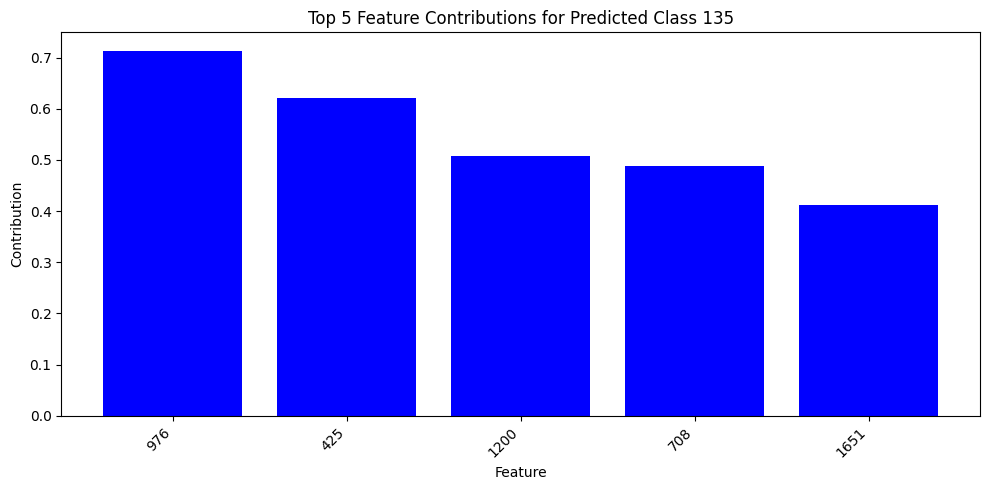

True Class: Barn_Swallow
Predicted Class: Barn_Swallow


In [8]:
id_image = 2000

concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

3810


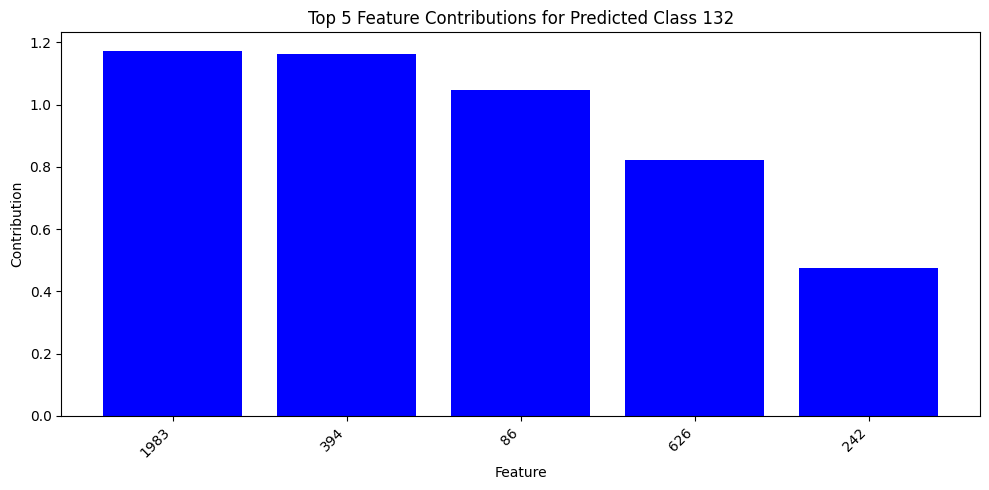

True Class: White_throated_Sparrow
Predicted Class: White_throated_Sparrow
cervical 0
juvenile 1
senegal 2
juvenile 4
blu 10
['../Segments/CUB_200_2011_SAM2/crops/081.Pied_Kingfisher/Pied_Kingfisher_0011_72143_OUT_CROP_0_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/081.Pied_Kingfisher/Pied_Kingfisher_0019_72659_OUT_CROP_0_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/081.Pied_Kingfisher/Pied_Kingfisher_0017_72316_OUT_CROP_0_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/081.Pied_Kingfisher/Pied_Kingfisher_0061_72193_OUT_CROP_1_X_.jpg', '../Segments/CUB_200_2011_SAM2/crops/088.Western_Meadowlark/Western_Meadowlark_0017_78940_OUT_CROP_2_X_.jpg']
../Segments/CUB_200_2011_SAM2/crops/081.Pied_Kingfisher/Pied_Kingfisher_0011_72143_OUT_CROP_0_X_.jpg
../Segments/CUB_200_2011_SAM2/crops/081.Pied_Kingfisher/Pied_Kingfisher_0019_72659_OUT_CROP_0_X_.jpg
../Segments/CUB_200_2011_SAM2/crops/081.Pied_Kingfisher/Pied_Kingfisher_0017_72316_OUT_CROP_0_X_.jpg
../Segments/CUB_200_2011_SAM2/crops/081.Pied_

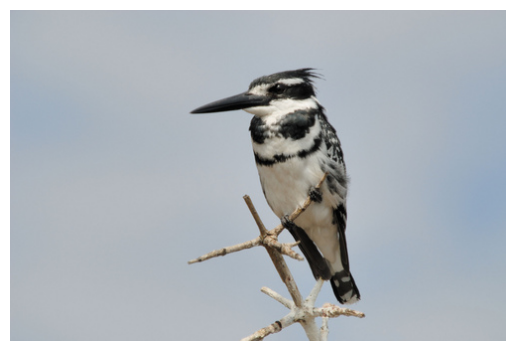

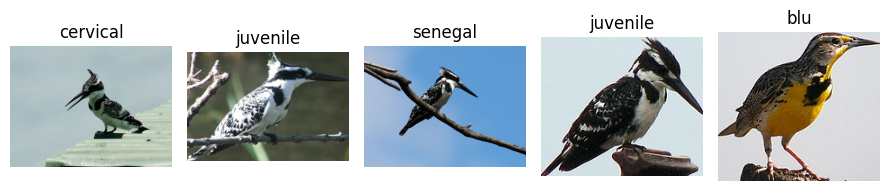

In [61]:
def display_images_with_main(image_paths, main_image_path, concept_names, num_secondary=5):
    """
    Display a main image prominently and a series of smaller images in a row layout.

    Parameters:
    - image_paths (list): List of file paths for the secondary images.
    - main_image_path (str): File path of the main image to be displayed larger.
    - num_secondary (int): Number of secondary images to display. Default is 5.
    """
    # Remove duplicates from image paths
    image_paths = image_paths[:num_secondary]
    # Display the main image
    main_img = Image.open(main_image_path)
    plt.imshow(main_img)
    plt.axis("off")

    # Set up the grid: main image in a larger size, followed by smaller images
    fig, axes = plt.subplots(1, num_secondary, figsize=(9, 4))

    # Display each of the secondary images
    for i, image_path in enumerate(image_paths):
        print(image_path)
        img = cv2.imread(image_path)
        try:
            axes[i].imshow(img)
        except:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(concept_names[i])

    plt.tight_layout()
    plt.show()


def display_concepts(id_image, cbm, raw_path, raw_path_dataset):

    def extract_until_number(strings):
        return [process_string(s) for s in strings]

    def process_string(s):
        match = re.match(r"^([^0-9]+)", s)
        return match.group(1).strip("_") if match else s

    concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

    # Get the main image path

    folder_names = os.listdir(raw_path_dataset)
    image_name = list(cbm.data_test_raw.keys())[id_image]
    folder_name = process_string(image_name)
    for i in range(len(folder_names)):
        if folder_name.lower() in folder_names[i].lower():
            folder_name = folder_names[i]
            break
    image_path_org = os.path.join(raw_path_dataset, folder_name, image_name)
    # Find paths to median images based on feature importance (as in your example)
    image_median_paths = []
    concept_names = []
    for idx in concept_ids[:5]:
        idx = int(idx)
        clustered_concepts = cbm.clustered_concepts_all
        data = clustered_concepts[idx]
        median_values = np.median(data, axis=0)
        distances = np.sum(np.abs(data - median_values), axis=1)
        median_index = np.argmin(distances)
        clustered_images = cbm.image_segments_names
        median_index = np.argsort(distances)

        # Select up to n images closest to median
        n = 20
        median_entries = [clustered_images[idx][i] for i in median_index[:n]]

        concept_emb = data[median_index[0]]
        concept_emb = torch.tensor(concept_emb).to(device)
        sim = torch.nn.functional.cosine_similarity(concept_emb, text_features).cpu().float()

        top_index = sim.argsort(descending=True)
        concept_names.append(names[top_index[0]])
        
        # Process and add paths for the secondary images
        def construct_path(strings):
            correct_strings = []
            for substring in strings:
                folder_name = process_string(substring)
                for i in range(len(folder_names)):
                    if folder_name.lower() in folder_names[i].lower():
                        folder_name = folder_names[i]
                        break
                substring = os.path.join(raw_path, folder_name, substring)
                correct_strings.append(substring)
            return correct_strings

        image_median_paths.append(construct_path(median_entries)[0])
        # print(image_median_paths)

    # Call the function to display images
    display_images_with_main(image_median_paths, image_path_org, concept_names)


# Example usage:
id_image = random.randint(0, len(cbm.data_test_raw))
display_concepts(id_image, cbm, raw_path, raw_path_dataset)